**Universidade Federal de Minas Gerais**  
**Departamento de Ciência da Computação**  
**Aprendizado de Máquina**  
**Valéria Pereira de Souza**    

## Trabalho Prático 1 - Classificação de Exoplanetas

# Apresentação do problema

Um KOI - Kepler Object of Interest é uma corpo celeste que se suspeita ser um exoplaneta. A partir da observação de diversas características, o corpo é classificado como KOI e posteriormente, após novas verificações é feita a classificação dos KOI em "Confirmado" ou "Falso positivo". 

O objetivo é comparar o desempenho de diversos classificadores na tarefa de classificação automática de um KOI como exoplaneta confirmado ou falso positivo.

## 1. Inspeção, limpeza e preparação dos dados

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import warnings

warnings.filterwarnings('ignore')

In [3]:
INPUT_FILEPATH = "koi_data.csv"
TARGET = "koi_disposition"
N_FOLDS = 5

###### Inspeção Inicial

In [4]:
data_raw = pd.read_csv(INPUT_FILEPATH)
data_raw.head(5)

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


Observarmos 43 colunas, das quais uma se refere ao código de cada KOI e outra se refere à anotação do dado de interesse (y).

###### Tipos de dados

In [5]:
data_raw.dtypes

kepoi_name           object
koi_disposition      object
koi_period          float64
koi_impact          float64
koi_duration        float64
koi_depth           float64
koi_ror             float64
koi_srho            float64
koi_prad            float64
koi_sma             float64
koi_incl            float64
koi_teq             float64
koi_insol           float64
koi_dor             float64
koi_max_sngle_ev    float64
koi_max_mult_ev     float64
koi_model_snr       float64
koi_steff           float64
koi_slogg           float64
koi_smet            float64
koi_srad            float64
koi_smass           float64
koi_kepmag          float64
koi_gmag            float64
koi_rmag            float64
koi_imag            float64
koi_zmag            float64
koi_jmag            float64
koi_hmag            float64
koi_kmag            float64
koi_fwm_stat_sig    float64
koi_fwm_sra         float64
koi_fwm_sdec        float64
koi_fwm_srao        float64
koi_fwm_sdeco       float64
koi_fwm_prao        

###### Prepração do X, y

O dataset é composto majoritariamente por dados numéricos contínuos, não havendo necessidade de transformações de features categóricas. A coluna kepoi_name traz indentificadores únicos para cada instância. Dessa forma, não é uma feature discriminativa entre as classes e será desconsiderada. 

Após reservada em variável à parte, a coluna com as respostas também será removida do DataFrame

In [6]:
y = data_raw[TARGET]
X = data_raw.drop(columns=['kepoi_name', 'koi_disposition'])

###### Valores faltantes
Não existem valores faltantes

In [7]:
X.isnull().values.any()

False

###### Normalização

In [8]:
X.describe()

,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
count,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,...,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000
mean,37.032237,0.717106,5.607025,21340.318993,0.235205,3.415370,112.230798,0.158146,81.181413,1143.721069,...,-0.355681,-0.805629,-0.000263,0.000439,-0.049743,-0.087413,1.930251,-0.038402,-0.098738,1.920226
std,88.417985,2.628207,6.962634,66989.808550,2.586213,25.131368,3699.799318,0.241792,16.308839,775.788868,...,10.978677,14.741473,0.065707,0.077519,2.465670,2.746534,3.147553,2.465094,2.734732,3.142764
min,0.306940,0.000000,0.104600,0.800000,0.001290,0.000040,0.080000,0.007200,2.290000,92.000000,...,-275.600000,-397.620000,-4.000000,-0.800000,-21.500000,-75.900000,0.000000,-23.600000,-76.600000,0.000000
25%,2.213962,0.226000,2.500250,176.800000,0.013058,0.176092,1.460000,0.033000,81.930000,615.250000,...,-0.500000,-0.570000,-0.000240,-0.000240,-0.270000,-0.291500,0.128250,-0.265250,-0.320000,0.180000
50%,7.386755,0.610000,3.805500,495.950000,0.024185,0.748045,2.600000,0.073650,87.890000,948.000000,...,0.000000,-0.030000,0.000000,0.000000,0.000000,0.000000,0.460000,-0.007000,-0.018000,0.453000
75%,23.448117,0.923750,6.000750,2120.525000,0.171260,2.267063,21.645000,0.158200,89.520000,1482.000000,...,0.500000,0.450000,0.000260,0.000280,0.230000,0.230000,2.570000,0.226250,0.250000,2.420000
max,1071.232620,100.806000,138.540000,864260.000000,99.870650,918.752390,200346.000000,2.034500,90.000000,9791.000000,...,97.780000,98.780000,1.190000,5.000000,45.680000,27.500000,88.600000,46.570000,31.200000,89.600000


Observarmos grande variância na escala de valores das features. Esse fato pode representar um problema para algoritmos paramétricos uma vez que features com valores mais extremos influenciarão mais o resultado enviesando artificalmente os modelos. Para evitar esse tipo de problema, faremos um procedimento de feature scaling pela técnica de normalização no intervalo (0, 1)

In [9]:
# Normalização das features
X = pd.DataFrame(minmax_scale(X, feature_range=(0, 1)))
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,...,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000
mean,0.034293,0.007114,0.039747,0.024691,0.002342,0.003717,0.000560,0.074457,0.899457,0.108436,...,0.737169,0.799384,0.770662,0.138007,0.319295,0.733197,0.021786,0.335779,0.709659,0.021431
std,0.082562,0.026072,0.050295,0.077511,0.025896,0.027354,0.018467,0.119268,0.185940,0.079986,...,0.029403,0.029697,0.012660,0.013365,0.036702,0.026562,0.035525,0.035130,0.025369,0.035075
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001781,0.002242,0.017305,0.000204,0.000118,0.000192,0.000007,0.012726,0.907992,0.053949,...,0.736783,0.799859,0.770667,0.137890,0.316017,0.731223,0.001448,0.332546,0.707607,0.002009
50%,0.006611,0.006051,0.026734,0.000573,0.000229,0.000814,0.000013,0.032778,0.975943,0.088257,...,0.738122,0.800947,0.770713,0.137931,0.320036,0.734043,0.005192,0.336226,0.710408,0.005056
75%,0.021609,0.009164,0.042591,0.002453,0.001702,0.002468,0.000108,0.074483,0.994527,0.143314,...,0.739461,0.801914,0.770763,0.137979,0.323459,0.736267,0.029007,0.339550,0.712894,0.027009
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


###### Encoding dos valores alvo

In [10]:
print(y[0:5])

0         CONFIRMED
1         CONFIRMED
2    FALSE POSITIVE
3         CONFIRMED
4    FALSE POSITIVE
Name: koi_disposition, dtype: object


In [11]:
label_encoder = LabelEncoder()
label_encoder.fit(['FALSE POSITIVE', 'CONFIRMED'])
y = label_encoder.transform(y)
print(y[0:5])

[0 0 1 0 1]


## 2. Experimentos

#### *Classe utilitária*

In [84]:
class Experiment():
    def __init__(self):

        self.X_train, self.X_test = [], []
        self.y_train, self.y_test = [], []
        self.train_index, self.test_index = [], []
        self.train_pred, self.test_pred = [], []
        self.clf = None
        self.accuracy_train, self.accuracy_test = [], []
        self.precision_train, self.precision_test = [], []
        self.recall_train, self.recall_test = [], []
        self.f1_train, self.f1_test = [], []
        
        self.mean_accuracy_train = 0
        self.mean_accuracy_test = 0
        self.mean_precision_train = 0
        self.mean_precision_test = 0
        self.mean_recall_train = 0
        self.mean_recall_test = 0
        self.mean_f1_train = 0
        self.mean_f1_test = 0
        
        self.fpr_fold = []
        self.tpr_fold = []
        self.mean_fpr = 0
        self.mean_tpr = 0
        self.test_pred_proba=0

    def run_naive_bayes(self):
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            self.clf = GaussianNB()
            self.clf = self.clf.fit(self.X_train, self.y_train)
            self.get_predictions(self.clf)
            self.get_metrics_per_fold()
        self.get_means()
    
    def run_decision_tree(self, depth):
        mean_fpr = np.linspace(0,1,100)
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            self.clf = DecisionTreeClassifier(max_depth=depth)
            self.clf = self.clf.fit(self.X_train, self.y_train)
            self.get_predictions(self.clf)
            self.get_metrics_per_fold()
        self.get_means()
                
    def run_svm(self, kernel, C=None):
        i=1
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            if not C:
                self.clf = SVC(kernel=kernel, probability=True, C=1)
            else:
                self.clf = SVC(kernel=kernel, probability=True, C=C)
            self.clf = self.clf.fit(self.X_train, self.y_train)
            self.get_predictions(self.clf)
            self.get_metrics_per_fold()
            i+=1
        self.get_means()          
    
    def run_knn(self, k):
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            self.clf = KNeighborsClassifier(n_neighbors=k)
            self.clf = self.clf.fit(self.X_train, self.y_train)
            self.get_predictions(self.clf)
            self.get_metrics_per_fold()
        self.get_means()
    
    def run_rf(self, n_estimators):
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            self.clf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
            self.clf = self.clf.fit(self.X_train, self.y_train)
            self.get_predictions(self.clf)
            self.get_metrics_per_fold()
        self.get_means()
        
    def run_gb(self, estimators):
        for self.train_index, self.test_index in self.get_folds():
            self.slice_fold()            
            self.clf = GradientBoostingClassifier(n_estimators=estimators)
            self.clf = self.clf.fit(self.X_train, self.y_train)
            self.get_predictions(self.clf)
            self.get_metrics_per_fold()
        self.get_means()
        
    def get_folds(self):
        kfold = KFold(N_FOLDS, True, 1)
        return kfold.split(X)

    def slice_fold(self):
        global X
        global y
        self.X_train = X.iloc[self.train_index]
        self.y_train = y[self.train_index]
        
        self.X_test = X.iloc[self.test_index]
        self.y_test = y[self.test_index]
         
    def get_predictions(self, clf):
        self.train_pred = clf.predict(self.X_train)
        self.test_pred = clf.predict(self.X_test)
        
    def get_metrics_per_fold(self):
        self.accuracy_train.append(accuracy_score(self.y_train, self.train_pred))
        self.accuracy_test.append(accuracy_score(self.y_test, self.test_pred))
        
        self.precision_train.append(precision_score(self.y_train, self.train_pred))
        self.precision_test.append(precision_score(self.y_test, self.test_pred))
        
        self.recall_train.append(recall_score(self.y_train, self.train_pred))
        self.recall_test.append(recall_score(self.y_test, self.test_pred))
        
        self.f1_train.append(f1_score(self.y_train, self.train_pred))
        self.f1_test.append(f1_score(self.y_test, self.test_pred))
        
        
        
    def get_means(self):
        self.mean_accuracy_train = np.mean(self.accuracy_train)
        self.mean_accuracy_test = np.mean(self.accuracy_test)
        self.mean_precision_train = np.mean(self.precision_train)
        self.mean_precision_test = np.mean(self.precision_test)
        self.mean_recall_train = np.mean(self.recall_train)
        self.mean_recall_test = np.mean(self.recall_test)
        self.mean_f1_train = np.mean(self.f1_train)
        self.mean_f1_test = np.mean(self.f1_test)
#         self.mean_fpr = np.mean(self.fpr_fold)
#         self.mean_tpr = np.mean(self.tpr_fold)
        
    def print_results(self):
        print("Train")
        print("  Accuracy: {:.3f}".format(self.mean_accuracy_train))
        print("  Precision: {:.3f}".format(self.mean_precision_train))
        print("  Recall: {:.3f}".format(self.mean_recall_train))
        print("  f1: {:.3f}".format(self.mean_f1_train))

        print()
        
        print("Test")
        print("  Accuracy: {:.3f}".format(self.mean_accuracy_test))
        print("  Precision: {:.3f}".format(self.mean_precision_test))
        print("  Recall: {:.3f}".format(self.mean_recall_test))
        print("  f1: {:.3f}".format(self.mean_f1_test))


In [57]:
def save_results(objeto, metrics = {}):
    """ 
    Função auxiliar que salva resultados de muitos experimentos
    """    
    metrics['accuracy_train'].append(objeto.mean_accuracy_train)
    metrics['accuracy_test'].append(objeto.mean_accuracy_test)
                            
    metrics['precision_train'].append(objeto.mean_precision_train)
    metrics['precision_test'].append(objeto.mean_precision_test)
    
    metrics['recall_train'].append(objeto.mean_recall_train)
    metrics['recall_test'].append(objeto.mean_recall_test)
    
    metrics['f1_train'].append(objeto.mean_f1_train)
    metrics['f1_test'].append(objeto.mean_f1_test)
  
    return metrics

In [58]:
def plot_results(x, metrics, baseline, name='Decision Tree', parameter='Altura'):
    
    plt.subplot()
    plt.title(name + ' - ACCURACY')
    plt.xlabel(parameter)
    plt.ylabel('Accuracy')
    plt.axhline(baseline.mean_accuracy_test, linestyle='--', color='grey')
    plt.plot(x, metrics['accuracy_train'], label = 'treino')
    plt.plot(x, metrics['accuracy_test'], label = 'teste')
    plt.legend(loc='best')
    plt.show()

    plt.subplot()
    plt.title(name + ' - F1 SCORE')
    plt.xlabel(parameter)
    plt.ylabel('f1 score')
    plt.axhline(baseline.mean_f1_test, linestyle='--', color='grey')
    plt.plot(x, metrics['f1_train'], label = 'treino')
    plt.plot(x, metrics['f1_test'], label = 'teste')
    plt.legend(loc='best')
    plt.show()

In [110]:
from matplotlib.pyplot import figure
def roc_compare(baseline, best_dt, best_svm, best_knn, best_rf, best_gb):
    
    # Baseline
    probs = baseline.clf.predict_proba(baseline.X_test)
    preds = probs[:,1]
    fpr_baseline, tpr_baseline, _ = roc_curve(baseline.y_test, preds)
    roc_auc_bl = auc(fpr_baseline, tpr_baseline)
    
    # Best DT
    probs = best_dt.clf.predict_proba(best_dt.X_test)
    preds = probs[:,1]
    fpr_dt, tpr_dt, _ = roc_curve(best_dt.y_test, preds)
    roc_auc_dt = auc(fpr_dt, tpr_dt)
    
    # Best SVM
    probs = baseline.clf.predict_proba(best_svm.X_test)
    preds = probs[:,1]
    fpr_svm, tpr_svm, _ = roc_curve(best_svm.y_test, preds)
    roc_auc_svm = auc(fpr_svm, tpr_svm)
    
    # Best knn
    probs = best_knn.clf.predict_proba(best_knn.X_test)
    preds = probs[:,1]
    fpr_knn, tpr_knn, _ = roc_curve(best_knn.y_test, preds)
    roc_auc_knn = auc(fpr_knn, tpr_knn)
    
    #best_rf
    probs = best_rf.clf.predict_proba(best_rf.X_test)
    preds = probs[:,1]
    fpr_rf, tpr_rf, _ = roc_curve(best_rf.y_test, preds)
    roc_auc_rf = auc(fpr_rf, tpr_rf)
    
    # best GB
    probs = best_gb.clf.predict_proba(best_gb.X_test)
    preds = probs[:,1]
    fpr_gb, tpr_gb, _ = roc_curve(best_gb.y_test, preds)
    roc_auc_gb = auc(fpr_gb, tpr_gb)

    # GRAPH
    plt.title('ROC - Comparativo')
#     plt.figure(num=None, figsize=(15, 15), dpi=80, facecolor='w', edgecolor='k')

    plt.plot(fpr_baseline, tpr_baseline, 'brown', label = 'Baseline AUC = %0.4f' % roc_auc_bl)
    plt.plot(fpr_dt, tpr_dt, 'green', label = 'DT AUC = %0.4f' % roc_auc_dt)
    plt.plot(fpr_svm, tpr_svm, 'orange', label = 'SVM AUC = %0.4f' % roc_auc_svm)
    plt.plot(fpr_knn, tpr_knn, 'fuchsia', label = 'KNN AUC = %0.4f' % roc_auc_knn)
    plt.plot(fpr_rf, tpr_rf, 'red', label = 'RF AUC = %0.4f' % roc_auc_rf)
    plt.plot(fpr_gb, tpr_gb, 'blue', label = 'GB AUC = %0.4f' % roc_auc_gb)
    
    

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [61]:
def plot_compare_svm():
    n_groups = 4
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.1

    objects = ('Linear', 'Sigmoid', 'Polinomial', 'RBF')
    acc = [linear_svm.mean_accuracy_test, 
           sigmoid_svm.mean_accuracy_test, 
           poly_svm.mean_accuracy_test, 
           rbf_svm.mean_accuracy_test]
    prec = [linear_svm.mean_precision_test, 
            sigmoid_svm.mean_precision_test, 
            poly_svm.mean_precision_test, 
            rbf_svm.mean_precision_test]
    recall = [linear_svm.mean_recall_test, 
              sigmoid_svm.mean_recall_test, 
              poly_svm.mean_recall_test, 
              rbf_svm.mean_recall_test]
    f1 = [linear_svm.mean_f1_test, 
          sigmoid_svm.mean_f1_test, 
          poly_svm.mean_f1_test, 
          rbf_svm.mean_f1_test]

    rects1 = plt.bar(index, acc, bar_width, color='blue', label='accuracy')
    rects2 = plt.bar(index + bar_width, prec, bar_width, color='green', label='precision')
    rects3 = plt.bar(index + 2*bar_width, recall, bar_width, color='orange', label='recall')
    rects4 = plt.bar(index + 3*bar_width, f1, bar_width, color='red', label='f1')


    plt.xlabel('Kernels')
    plt.ylabel('f1 scores')
    plt.title('Metricas de teste por Kernel')
    plt.axhline(baseline.mean_f1_test, linestyle='--', color='grey')

    plt.xticks(index + bar_width, ('Linear', 'Sigmoid', 'Polinomial', 'RBF'))
    plt.legend()
    plt.show()


In [62]:
def plot_compare_models(models, baseline):
    #models is a list of objects
    n_groups = len(models)
    fig, ax = plt.subplots()
    index = np.arange(n_groups)
    bar_width = 0.1

    objects = ('Linear', 'Sigmoid', 'Polinomial', 'RBF')
    acc = [models[0].mean_accuracy_test, 
           models[1].mean_accuracy_test, 
           models[2].mean_accuracy_test, 
           models[3].mean_accuracy_test,
           models[4].mean_accuracy_test]
    
    prec = [models[0].mean_precision_test, 
           models[1].mean_precision_test, 
           models[2].mean_precision_test, 
           models[3].mean_precision_test,
           models[4].mean_precision_test]
    
    recall = [models[0].mean_recall_test, 
           models[1].mean_recall_test, 
           models[2].mean_recall_test, 
           models[3].mean_recall_test,
           models[4].mean_recall_test]
    
    f1 = [models[0].mean_f1_test, 
           models[1].mean_f1_test, 
           models[2].mean_f1_test, 
           models[3].mean_f1_test,
           models[4].mean_f1_test]

    rects1 = plt.bar(index, acc, bar_width, color='blue', label='accuracy')
    rects2 = plt.bar(index + bar_width, prec, bar_width, color='green', label='precision')
    rects3 = plt.bar(index + 2*bar_width, recall, bar_width, color='orange', label='recall')
    rects4 = plt.bar(index + 3*bar_width, f1, bar_width, color='red', label='f1')

    plt.xlabel('Models')    
    axes = plt.gca()
    axes.set_ylim([0.75, 1.0])
    plt.title('Metricas de teste por Modelo')
    plt.axhline(baseline.mean_accuracy_test, linestyle='--', color='grey')
    plt.xticks(index + bar_width, ('DecTree', 'SVM', 'kNN', 'RF', 'GB'))
    plt.legend()
    plt.show()

In [108]:
def accuracy_compare(baseline, best_dt, best_svm, best_knn, best_rf, best_gb):
    print("Acurácia de Teste")
    print("  Baseline...........{:.3f}".format(baseline.mean_accuracy_test))
    print("  Decision Tree......{:.3f}".format(best_dt.mean_accuracy_test))
    print("  SVM................{:.3f}".format(best_svm.mean_accuracy_test))
    print("  kNN................{:.3f}".format(best_knn.mean_accuracy_test))
    print("  Random Forest......{:.3f}".format(best_rf.mean_accuracy_test))
    print("  Gradient Boosting..{:.3f}".format(best_gb.mean_accuracy_test))

### 2.1 Naive Bayes - Baseline

O algoritmo Naive Bayes calcula a probabilidade condicional de cada feature dado o rótulo observado. Como não conhecemos a distribuição dos dados e, levando em consideração que fenômenos complexos tendem à distribuição normal, será utlizada a implementação Gaussian Naive Bayes.

In [85]:
baseline = Experiment()
baseline.run_naive_bayes()
baseline.print_results()

Train
  Accuracy: 0.917
  Precision: 0.980
  Recall: 0.878
  f1: 0.926

Test
  Accuracy: 0.918
  Precision: 0.980
  Recall: 0.880
  f1: 0.927


### 2.2 Decision Trees

Decision Tree é um classificador não paramétrico baseado na escolha de features que melhor dividam os dados, ou seja, divisões que resultem em subconjuntos com menor entropia do que o anterior. A cada nível da árvore, o conjunto vai sendo subdivido a partir da feature que seja mais discriminativa. 

Isso significa que, se a árvore puder crescer livremente, os nós folha conterão, em cada folha, apenas instâncias do mesmo label (entropia zero). Nesse cenário, o acerto do modelo é total para os dados de treino incorrendo em forte overfitting, no qual nosso modelo perde poder de generalização. A altura é, portanto, o hiperparâmetro de interesse.

**Hiperparâmetro variado: altura**


#### 2.2.1 Altura: ilimitada

**A | Objetivo do experimento**<br>
Neste experimento, observaremos um árvores crescer de forma ilimitada e atingir desempenho de 100% no dado de treino com resultado inferior no dado de teste, evidenciando o overfitting.

**B | Resultados**

In [21]:
no_prunning = Experiment()
no_prunning.run_decision_tree(None)
no_prunning.print_results()

Train
  Accuracy: 1.000
  Precision: 1.000
  Recall: 1.000
  f1: 1.000

Test
  Accuracy: 0.946
  Precision: 0.954
  Recall: 0.955
  f1: 0.954


**C | Análise do resultado** <br>
O desempenho de 100% em todas as métricas evidencia que o modelo decorou regras de decisão totalmente específicas para o dado de treino. O resultado inferior no dado de teste mostra que, ao decorar, as regras aprendidas pelo modelo não sao capazes de generalizar tão bem para dados nunca vistos antes - dado de teste.

###### 2.2.2 Altura: variando de 1 a 30

**A | Objetivo do experimento**<br>
Para reduzir o problema do overfitting, e melhorar o poder de generalização do nosso modelo, vamos testar diferente limites de altura para a árvore. 

In [63]:
metrics_dt={
    'accuracy_train':[],
    'precision_train':[],
    'recall_train':[],
    'f1_train':[],
    'accuracy_test':[],
    'precision_test':[],
    'recall_test':[],
    'f1_test':[]
}

espaco_de_busca_dt = range(1, 30+1) 

for i in tqdm(espaco_de_busca_dt):
    decision_tree = Experiment()
    decision_tree.run_decision_tree(i)
    metrics = save_results(decision_tree, metrics_dt)

**B | Resultados**

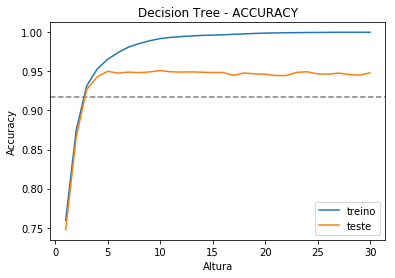

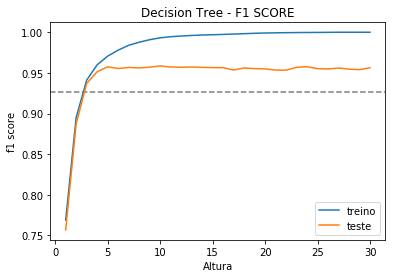

In [64]:
plot_results(espaco_de_busca_dt, metrics_dt, baseline, name='Decision Tree', parameter='Altura')

In [65]:
print('Acurácia teste')
for i in espaco_de_busca_dt:    
    print(i, ':{:.3f} '.format(metrics['accuracy_test'][i-1]))

Acurácia teste
1 :0.747 
2 :0.865 
3 :0.927 
4 :0.943 
5 :0.950 
6 :0.948 
7 :0.949 
8 :0.948 
9 :0.949 
10 :0.951 
11 :0.949 
12 :0.949 
13 :0.949 
14 :0.949 
15 :0.948 
16 :0.948 
17 :0.945 
18 :0.948 
19 :0.947 
20 :0.946 
21 :0.945 
22 :0.945 
23 :0.949 
24 :0.949 
25 :0.947 
26 :0.946 
27 :0.948 
28 :0.946 
29 :0.945 
30 :0.948 


**C | Análise do resultado**

A partir da altura 5, o desempenho de teste não apresenta melhoria relevante, ao tempo em que o desempenho de treino continua aumentando, o que evidenci o overfitting a partir desse ponto. Para altura 5, a árvore de decisão, apesar de ser um modelos simples, obteve desempenho f1-teste melhor do que o baseline: 0.958 contra 0.927 e acurácia de 0.950 contra 0.918.

**Resultado preliminar - Acurácia de Teste**<br>
Baseline..............................0.918<br>
Decision Tree (depth=5).....0.950

In [66]:
# Decision Tree depth=5
best_dt = Experiment()
best_dt.run_decision_tree(5)
best_dt.print_results()

Train
  Accuracy: 0.965
  Precision: 0.983
  Recall: 0.958
  f1: 0.971

Test
  Accuracy: 0.950
  Precision: 0.971
  Recall: 0.945
  f1: 0.958


### 3.2 SVM

O SVM é um algoritmo que tenta identificar o hiperplano que melhor separe os dados de cada classe. De todos os hiperplanos possíveis, o SVM tentará modelar aquele que maximiza a margem, ou seja a distância do hiperplano para os pontos mais próximos, denominados "suport vectors". Quanto maior a quantidade de support vector, mais restrito fica o espaço de busca de hiperplanos e maior a chance de overfitting.

A tarefa não é simples dado que, na maioria dos cenários, os dados não são linearmente separáveis. Para atingir seu objetivo, o SVM atua com um hiperparâmetro chamado **Kernel**, que aplica transformações nos dados de maneira a  alterar a disposição dos pontos no espaço multidimensional, na tentativa de torná-los mais linearmente separáveis.

A tentativa de separar completamente os dados, entretanto, pode resultar em modelo da alta complexidade que causa overfitting. Dessa forma, o hiperparâmetro **C** é utilizado como forma de regularização ao permitir algumas classificações erradas. 

Para kernels que realizam transformações não lineares, é possível variar também o hiperparâmetro **gamma**, entretanto, por questões de viabilidade de tempo, esse hiperparâmetro será fixado como 'auto', valor padrão da biblioteca sklearn.

**Hiperparâmetros variados: kernel. Para o melhor kernel, será variado o hiperparâmetro C**

##### 3.2.1 Verificação do desempenho de diversos kernels
**A | Objetivo do experimento**<br>
Explorar como a utilização de vários kernels afeta o desempenho do modelo

**Linear Kernel**<br>

In [24]:
linear_svm = Experiment()
linear_svm.run_svm('linear')
linear_svm.print_results()

Train
  Accuracy: 0.914
  Precision: 0.952
  Recall: 0.901
  f1: 0.926

Test
  Accuracy: 0.912
  Precision: 0.951
  Recall: 0.899
  f1: 0.924


**Sigmoid Kernel**

In [25]:
sigmoid_svm = Experiment()
sigmoid_svm.run_svm('sigmoid')
sigmoid_svm.print_results()

Train
  Accuracy: 0.746
  Precision: 0.720
  Recall: 0.937
  f1: 0.814

Test
  Accuracy: 0.744
  Precision: 0.719
  Recall: 0.937
  f1: 0.813


**Polinomial Kernel**

In [26]:
poly_svm = Experiment()
poly_svm.run_svm('poly')
poly_svm.print_results()

Train
  Accuracy: 0.613
  Precision: 0.607
  Recall: 0.995
  f1: 0.754

Test
  Accuracy: 0.613
  Precision: 0.607
  Recall: 0.995
  f1: 0.754


**RBF Kernel**

In [27]:
rbf_svm = Experiment()
rbf_svm.run_svm('rbf')
rbf_svm.print_results()

Train
  Accuracy: 0.823
  Precision: 0.817
  Recall: 0.905
  f1: 0.859

Test
  Accuracy: 0.822
  Precision: 0.816
  Recall: 0.905
  f1: 0.858


**B | Resultado**

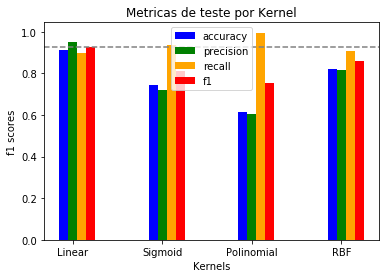

In [28]:
plot_compare_svm()

**C | Análise dos resultados**

Dos 4 kernels testados, o linear apresentou o melhor resultado para a métrica F1. Esse kernel é apropriado quando sabe-se que os dados são linearmente separáveis, ou quando temos alta dimensionalidade, o que pode ter sido o caso.

É interessante notar que o kernel polinomial apresentou um resultado alto para a métrica *recall*, que varificar a proporção de True Positives, ou seja, ele se saiu bem em identificar o maior número exoplantes confirmados, mas nesse processo, também avaliou errado uma alta quantidade de falsos positivos (baixa precision)

**D | Variando o hiperparâmetro C**<br>
Faremos agora a variação do hiperparâmetro C na tentativa de identificar um modelo com melhor desempenho para o kernel linear

In [72]:
metrics_svm = {
    'accuracy_train':[],
    'precision_train':[],
    'recall_train':[],
    'f1_train':[],
    'accuracy_test':[],
    'precision_test':[],
    'recall_test':[],
    'f1_test':[]
}

espaco_de_busca_svm = [1, 10, 100, 500]
for C in tqdm(espaco_de_busca_svm):
    search_svm = Experiment()
    search_svm.run_svm('linear', C)
    metrics_search_svm = save_results(search_svm, metrics_svm)

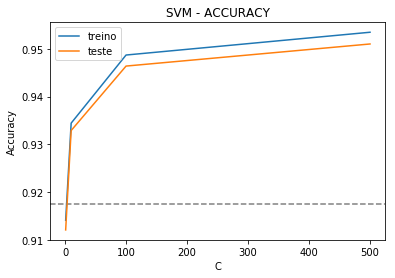

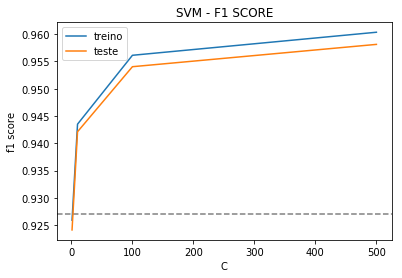

In [74]:
plot_results(espaco_de_busca_svm, metrics_search_svm, baseline, name='SVM', parameter='C')

**E | Análise do resultados**<br>
Variando o C, foi possível melhorar o desempenho. Observamos que o desempenho de testes continua subindo no mesmo ritmo que o desempenho de treino, sugerindo que o overfitting ainda não ocorreu. Poderíamos continuar buscando novos valores de C, caso o desempenho do modelo fosse o objetivo. Por ora, prosseguiremos com o melhor modelo identificado até aqui: kernel linear com C=500.

**Resultado preliminar - Acurácia de Teste**<br>
Baseline..............................0.918<br>
Decision Tree (depth=5).....0.950<br>
SVM (linear, C=500)...........0.951

In [75]:
best_svm = Experiment()
best_svm.run_svm('linear', 500)
best_svm.print_results()

Train
  Accuracy: 0.953
  Precision: 0.974
  Recall: 0.947
  f1: 0.960

Test
  Accuracy: 0.951
  Precision: 0.973
  Recall: 0.944
  f1: 0.958


### 3.3 kNN

**A | Objetivo do experimento**<br>
O K-nearest neighbors faz a classificação de cada ponto com base observando o rótulo dos **k** vizinhos e decidindo o rótulo do ponto pela maioria dos rótulos observados.

**Hiperparâmetro a ser variado: k**

In [32]:
metrics_knn = {
    'accuracy_train':[],
    'precision_train':[],
    'recall_train':[],
    'f1_train':[],
    'accuracy_test':[],
    'precision_test':[],
    'recall_test':[],
    'f1_test':[]
}

espaco_de_busca_knn = [i for i in range(3,17+1, 2)]
for k in tqdm(espaco_de_busca_knn):
    knn = Experiment()
    knn.run_knn(k)
    metrics_knn = save_results(knn, metrics_knn)

**B | Resultados**

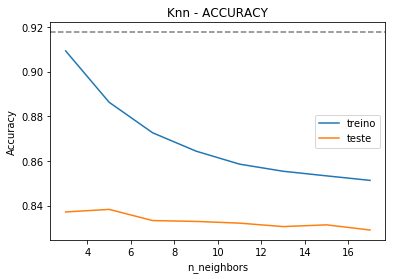

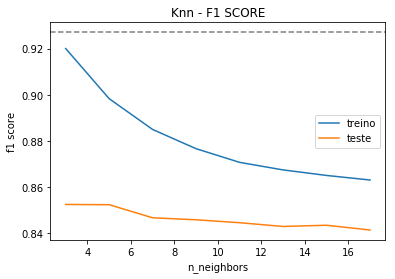

In [33]:
plot_results(espaco_de_busca_knn, metrics_knn, baseline, name='Knn', parameter='n_neighbors')

In [34]:
print('Acurácia teste')
for i, item in enumerate(espaco_de_busca_knn):
    print(item, ':{:.3f} '.format(metrics_knn['accuracy_test'][i]))

Acurácia teste
3 :0.837 
5 :0.838 
7 :0.833 
9 :0.833 
11 :0.832 
13 :0.831 
15 :0.831 
17 :0.829 


**C | Análise**<br>
Com baixos valores de k, o modelo apresenta forte overfitting uma vez que a percepção do modelo fica restrita a pontos muito próximos. Isso faz com que o modelo tenha pouco dado para embasar sua decisão, causando o overfitting. Entretanto, mesmo aumentando o valor de k, o melhor resultado fica em k=5 e não melhoramos o desempenho do modelo, que fica abaixo do baseline para todos os cassos testados.

**Resultado preliminar - Acurácia de Teste**<br>
Baseline..............................0.918<br>
Decision Tree (depth=5).....0.950<br>
SVM (linear, C=500)...........0.951<br>
kNN (k=5)...........................0.838

In [77]:
best_knn = Experiment()
best_knn.run_knn(5)
best_knn.print_results()

Train
  Accuracy: 0.886
  Precision: 0.960
  Recall: 0.844
  f1: 0.898

Test
  Accuracy: 0.838
  Precision: 0.934
  Recall: 0.784
  f1: 0.852


### 3.4 Random Forest

Esse algoritmo é um ensemble de árvores de decisão. Árvores são particularmente suscetíveis a overfitting. A técnica de bagging utilizada pela Random Forest tenta minimizar esse problema por meio de duas técnicas.

*1 - Bootstrap aggregation*: A partir do dataset de treino, são escolhidas aleatoriamente X instâncias para formar um subdataset no qual uma árvore será treinada. O processo é realizado tantas vezes quantas forem as árvores a serem treinadas, com reposição das instâncias. Dessa forma, evita-se que as árvores overfittem para todas as instâncias do dataset de treino.<br>
*2 - Random projection*: A cada subdatset criado, também são selecionadas algumas features, de forma a evitar o overfitting para features.

Dados que os procedimentos acima são realizados uma vez para cada árvore a ser treinada, caso o **número de árvores** seja pequeno, frente ao tamanho do dataset, pode ocorrer de algumas instâncias e features serem pouco observadas ou sequer sejam observadas, incorrendo em underfitting. Os criadores do algoritmo alegam que o modelo não incorre em overfitting, entretanto, Segal (2004) identificou que o modelo entra em overfitting para alguns poucos datasets ruidosos.

**Hiperparâmetro a ser variado: número de árvores**<br>

**A | Objetivo do experimento**<br>
Observar o comportamento do desempenho da Random Forest ao se varia o hiperparâmetro n_estimators.

In [36]:
metrics_rf = {
    'accuracy_train':[],
    'precision_train':[],
    'recall_train':[],
    'f1_train':[],
    'accuracy_test':[],
    'precision_test':[],
    'recall_test':[],
    'f1_test':[]
}

espaco_de_busca_rf = [i for i in range(1,100+1, 2)]
for estimators in tqdm(espaco_de_busca_rf):
    rf = Experiment()
    rf.run_rf(estimators)
    metrics_rf = save_results(rf, metrics_rf)

**B | Resultados**

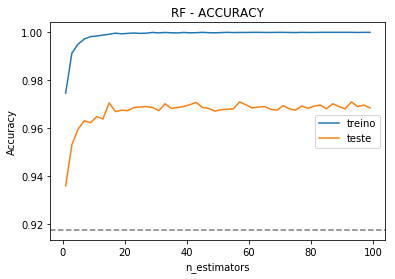

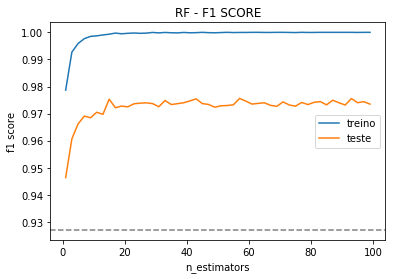

In [37]:
plot_results(espaco_de_busca_rf, metrics_rf, baseline, name='RF', parameter='n_estimators')

In [38]:
print('Acurácia Teste')
for i, item in enumerate(espaco_de_busca_rf):
    print(item, ':{:.3f} '.format(metrics_rf['accuracy_test'][i]))

Acurácia Teste
1 :0.936 
3 :0.953 
5 :0.960 
7 :0.963 
9 :0.962 
11 :0.965 
13 :0.964 
15 :0.971 
17 :0.967 
19 :0.968 
21 :0.967 
23 :0.969 
25 :0.969 
27 :0.969 
29 :0.969 
31 :0.967 
33 :0.970 
35 :0.968 
37 :0.969 
39 :0.969 
41 :0.970 
43 :0.971 
45 :0.969 
47 :0.968 
49 :0.967 
51 :0.968 
53 :0.968 
55 :0.968 
57 :0.971 
59 :0.970 
61 :0.968 
63 :0.969 
65 :0.969 
67 :0.968 
69 :0.968 
71 :0.969 
73 :0.968 
75 :0.968 
77 :0.969 
79 :0.968 
81 :0.969 
83 :0.970 
85 :0.968 
87 :0.970 
89 :0.969 
91 :0.968 
93 :0.971 
95 :0.969 
97 :0.970 
99 :0.968 


**C | Análise**<br>
É muito interessante observar que, mesmo para um grande número de árvores, não se verifica indício de overfitting, conforme o esperado. O desempenho de treino atinge níveis muito altos, mas não leva a uma queda de desempenho no teste. Por outro lado, a partir de 20 árvores, o desempenho de teste não aumentou. Para que isso ocorresse, precisaríamos de mais dados de treino. Além disso, esse modelo atingiu a melhor acurácia até agora: 0.964

Selecionaremos n_estimators=13, dado que entre desempenhos que empatam, vamos privilegiar o menor custo computacional.

**Resultado preliminar - Acurácia de Teste**<br>
Baseline..............................0.918<br>
Decision Tree (depth=5).....0.950<br>
SVM (linear, C=500)...........0.951<br>
kNN (k=5)...........................0.838<br>
RF (n_estimators=13).........0.964

In [78]:
best_rf = Experiment()
best_rf.run_rf(13)
best_rf.print_results()

Train
  Accuracy: 0.999
  Precision: 0.999
  Recall: 1.000
  f1: 0.999

Test
  Accuracy: 0.968
  Precision: 0.971
  Recall: 0.975
  f1: 0.973


### 3.5 Gradient Tree Boosting

O Gradient Boosting utiliza o boosting como técnica de ensemble. O GB é uma variação do AdaBosst, no qual árvores extremamente simples (decision stumps) são cultivadas e, ao final, uma votação entre elas decide a classificação final. O GB altera a forma de cultivo dos classificadores fracos. Além de poderem ser ligeiramente maiores, as árvores são adicionadas uma a cada **iteração**. É utilizada uma função de otimização para informar a parametrização de cada árvore adicionada, tipicamente, o gradient descent. 

Dado que são utilizados classificadores fracos, o GB é robusto a overfitting, mas como a cada iteração, o erro dos classificadores anteriores é utilizado para cultivo da árvores seguinte, temos chance real de overfitting

**Hiperparâmetro variado: n_estimators (iterações)**

**A | Objetivo do experimento**<br>
Verificar o comportamento do desempenho ao se variar o número de iterações do Gradient Boosting

In [41]:
metrics_gb = {
    'accuracy_train':[],
    'precision_train':[],
    'recall_train':[],
    'f1_train':[],
    'accuracy_test':[],
    'precision_test':[],
    'recall_test':[],
    'f1_test':[]
}

espaco_de_busca_gb = [i for i in range(10,100+1, 10)]
for estimators in tqdm(espaco_de_busca_gb):
    gb = Experiment()
    gb.run_gb(estimators)
    metrics_gb = save_results(gb, metrics_gb)

**B | Resultados**

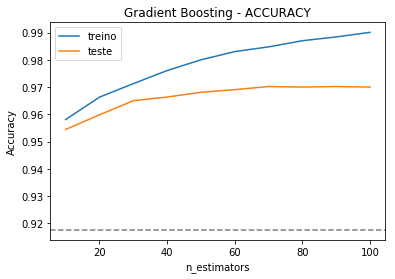

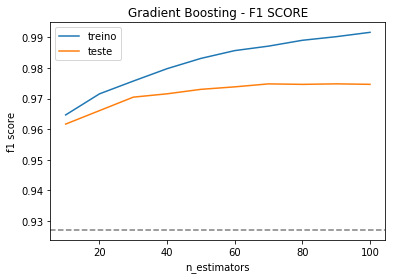

In [42]:
plot_results(espaco_de_busca_gb, metrics_gb, baseline, name='Gradient Boosting', parameter='n_estimators')

In [43]:
print('Acurácia de Teste')
for i, item in enumerate(espaco_de_busca_gb):
    print(item, ':{:.3f} '.format(metrics_gb['accuracy_test'][i]))

Acurácia de Teste
10 :0.954 
20 :0.960 
30 :0.965 
40 :0.966 
50 :0.968 
60 :0.969 
70 :0.970 
80 :0.970 
90 :0.970 
100 :0.970 


**C | Análise**<br>
O afastamento das curvas de treino e teste evidencia o overfitting. A partir de 70 iterações, o desempenho de teste não apresenta melhora significativa e aumenta o custo computacional. Dessa forma, será selecionado como melhor modelo deste experimento, o Gradient Boosting com 70 iterações

**Resultado preliminar - Acurácia de Teste**<br>
Baseline..............................0.918<br>
Decision Tree (depth=5).....0.950<br>
SVM (linear, C=500)...........0.951<br>
kNN (k=5)...........................0.838<br>
RF (n_estimators=13).........0.964<br>
GB (iterações = 70)............0.970

In [79]:
best_gb = Experiment()
best_gb.run_gb(70)
best_gb.print_results()

Train
  Accuracy: 0.985
  Precision: 0.991
  Recall: 0.983
  f1: 0.987

Test
  Accuracy: 0.970
  Precision: 0.980
  Recall: 0.970
  f1: 0.975


## 3. Análise comparativa entre os modelos

Observamos que o modelo Gradiente Boosting obteve o melhor desempenho dos 5 testados, com acurácia de teste de 0.970. Apenas o modelo kNN ficou abaixo do baseline para as métricas acurácia e f1 e também foi o que obteve maior variância nas métricas.

In [107]:
accuracy_compare(baseline, best_dt, best_svm, best_knn, best_rf, best_gb)

Acurácia de Teste
  Baseline...........0.918
  Decision Tree......0.950
  SVM................0.951
  kNN................0.838
  Random Forest......0.968
  Gradient Boosting..0.970


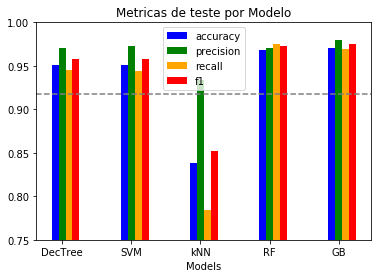

In [109]:
# Atenção, eixo y cropado
models = [best_dt, best_svm, best_knn, best_rf, best_gb]
plot_compare_models(models, baseline)

**ROC e AUC**

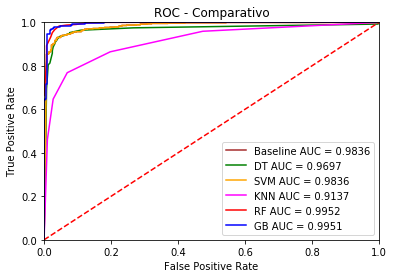

In [111]:
roc_compare(baseline, best_dt, best_svm, best_knn, best_rf, best_gb)

Um trade-off típico que acompanha classificações binárias é a true positives x false positive; o aumento de um vem acompanhado do decremento do outro. A curva ROC permite visualizar a dimensão desse trade-off. Essa informação é importante para decisões em problemas em que é desejado algum viés no sentido aumentar algum desses dois indicadores.

Observamos que o KNN apresenta grande trade-off, ou seja, caso deseje aumentar sua cobertura dos true positives, esse aumento também virá acompanhado de um aumento de false positives. A medida AUC - area under curve sumariza esse trade-off. Observamos que a RF e o GB apresenta empate estístico e que a DT ficou abaixo do AUC do baseline (NB).



## 4. Conclusão

Fica claro que cada algoritmo tem suas vantagens e desvantagens, dependendo da quantidade de dados, disposição dos pontos no espaço, custo computacional e desmepenho mínimo necessário, de acordo com a tarefa. Também é importante notar que pra certos problemas, podemos estar mais interessados em desmepenho de recall do que de precisão, como exames médicos por exemplo, e a escolha correta de hiperparâmetros é fundamental para atingir esse objetivo.

O tunning dos hiperparâmetros é fundamental para melhoria dos resultados e a validação cruzada foi essencial para explicitar a ocorrência ou não de overfitting de modo a permitir uma escolha mais segura dos hiperparâmetros para que, em produção, o modelo faça predições o mais acuradas possível em dados nunca antes vistos. Para além dasmétricas clássicas, a ROC apresenta informações adicionais que podem ser essenciais em decisões de tunning em função do problema em estudo.

Também fica claro como não é possível determinar receitas prontas de modelos, uma vez que cada dado e cada problema tem particularidades que precisam ser investigadas empiricamente.

###### Referências

* Rando Fortes. <https://www.stat.berkeley.edu/~breiman/RandomForests/cc_home.htm#remarks>. Acessado em 21/05/2019.
* Segal, Mark R. "Machine learning benchmarks and random forest regression." (2004).